# 2 - Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imagenes de articulos de vestimenta, el Fashion MNIST. 

### 2.a Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

In [0]:
import numpy as np
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Deconvolution2D, Reshape, Dropout
from keras.models import Sequential

In [0]:
from keras.datasets import fashion_mnist
(x_train,y_train),(x_val,y_val) = fashion_mnist.load_data()

import matplotlib.pyplot as plt

In [0]:
labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle-boot']
s = set(range(10))
view = list()

for i in range(x_train.shape[0]):
  if(y_train[i] in s):
    view.append((x_train[i],y_train[i]))
    s.remove(y_train[i])
  if(len(s)<1):
    break

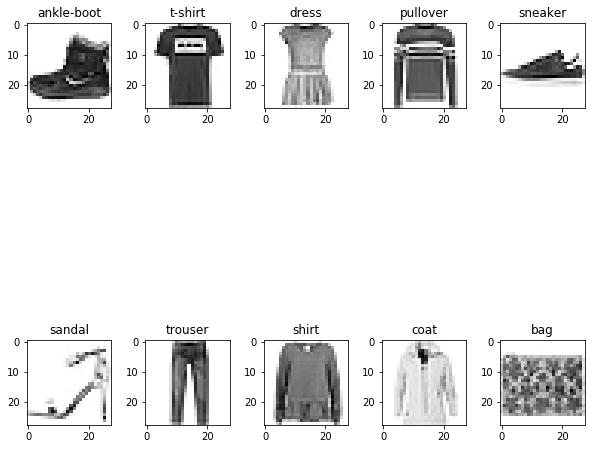

In [0]:
fig=plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 5
rows = 2
for i in range(1, columns*rows+1 ):
    img = view[i-1][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='Greys')
    plt.title(labels[view[i-1][1]])
plt.show()

0 T-shirt/top

1 Trouser

2 Pullover (polerón)

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot (botín)


  ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? 

El problema más importante recae en los objetos con siluetas similares, como los polerones con camisas, o las zapatillas con los botines. 

¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

Bastante bien pero por la calidad de imágenes podría incurrir en equivocaciones.

### 2.b Posibilidades de preprocesamiento y pequeños análisis. 

¿Cuáles son los rangos de valores de `x`? ¿Por qué?

¿Las distintas clases de ejemplos están balanceadas?

¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

In [0]:
print(np.min(x_train),np.max(x_train))

0 255


(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

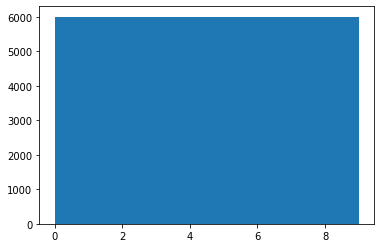

In [0]:
plt.hist(y_train)

In [0]:
x_train_scal = x_train/255
x_val_scal = x_val/255
x_val_vector = x_val.reshape(-1,28*28)
x_val_vector_scal = x_val_scal.reshape(-1,28*28)
x_train_vector = x_train.reshape(-1,28*28)
x_train_vector_scal = x_train_scal.reshape(-1,28*28)


In [0]:
x_val_vector.shape

(10000, 784)

* ¿Cuáles son los rangos de valores de x? ¿Por qué?

  Son valores de 0 a 255, debido a que es la intensidad de gris. Dado las imágenes en blanco y negro.

* ¿Las distintas clases de ejemplos están balanceadas?

  Al ser un dataset creado, está perfectamente equilibrado, como se ve en el histograma.

* ¿Considera necesario realizar un preprocesamiento? 

  Si, debido a que es más fácil de reconstruir al usar funciones con cotas más bajas y que evite que explote o se disparen los valores, por ejemplo que no se sature en 255 cuando los valores se hagan muy grandes. 


¿Se pierde información al realizar este preprocesamiento?

  No, debido a que es solamente un escalado de la intensidad a otro intervalo, que tenga mejores propiedades para nuestras funciones de activación más comunes.

### 2.c Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados, ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion? Grafique como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

In [0]:
from keras.layers import Dense
from keras.models import Sequential

autoencoder = Sequential()

autoencoder.add(Dense(32,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder.compile(loss='binary_crossentropy', optimizer='sgd')
    
history = autoencoder.fit(x_train_vector_scal,x_train_vector_scal,epochs=50,validation_data=(x_val_vector_scal,x_val_vector_scal))
              






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 15s 248us/step - loss: 0.6908 - val_loss: 0.6860
Epoch 2/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.6698 - val_loss: 0.6412
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.5926 - val_loss: 0.5502
Epoch 4/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.5320 - val_loss: 0.5221
Epoch 5/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.5176 - val_loss: 0.5149
Epoch 6/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.5121 - val_loss: 0.5103
Epoch 7/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.5076 - val_loss: 0.5057
Epoch 8/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.5026 - val_loss: 0.5002
E

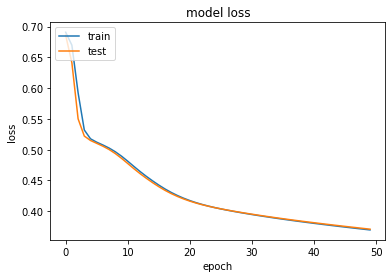

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

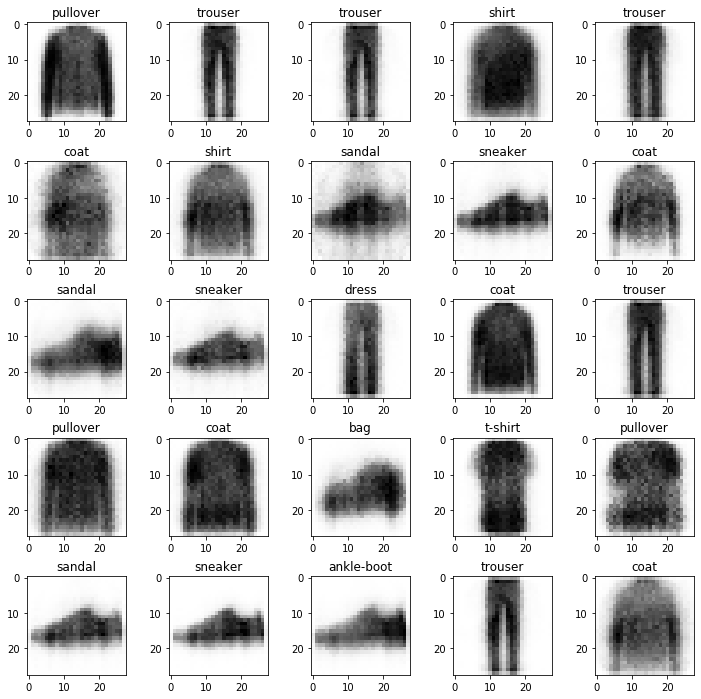

In [0]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 5
rows = 5
pred = autoencoder.predict(x_val_vector_scal)
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()


* Conjunto de datos escalados.  ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta?

  Debiera ser sigmoide debido al rango de salida que tiene, ya que debe generar datos escalados entre 0 y 1, y por ejemplo otras fucnioes como tanh o lineal, incurrirá en valores que no aparezcan, tanto por un intervalo menor como uno mayor. Por ende, si importa la función de activación elegida.

 * ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion?
 
 Se observa que aprende más bien las siluetas de losobjetos, generando problema en las clases parecidas, por ende, desde mi punto de vista veo difícil mejorar esa persepctiva, sobretodo por el blanco y negro de la imagen.



### 2.d Sin escalar
Entrene nuevamente la misma estructura de red pero esta vez utilizando los datos originales (sin escalar). ¿Qué función de activación debe utilizar para la capa de salida? ¿Le parece sea una buena aproximación comparando con las caracteristicas de la red anterior? 

Compare los desempeños viendo las imagenes reconstruidas. 

De aquí en adelante prefiera la versión de los datos escaladas para consistencia. 

In [0]:
autoencoder = Sequential()

autoencoder.add(Dense(32,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation='linear')) #decoder

autoencoder.compile(loss='sm', optimizer='sgd')
    
history = autoencoder.fit(x_train_vector,x_train_vector,epochs=50,validation_data=(x_val_vector,x_val_vector))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 90us/step - loss: -201.8703 - val_loss: -209.8128
Epoch 2/50
60000/60000 [==============================] - 5s 88us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 4/50
60000/60000 [==============================] - 5s 86us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 5/50
60000/60000 [==============================] - 5s 87us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 6/50
60000/60000 [==============================] - 5s 87us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 7/50
60000/60000 [==============================] - 5s 87us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 8/50
60000/60000 [==============================] - 5s 86us/step - loss: -209.5457 - val_loss: -209.8128
Epoch 9/50
60000/60000 [==============================] - 5s 8

KeyboardInterrupt: ignored

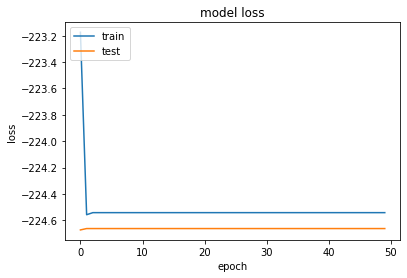

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

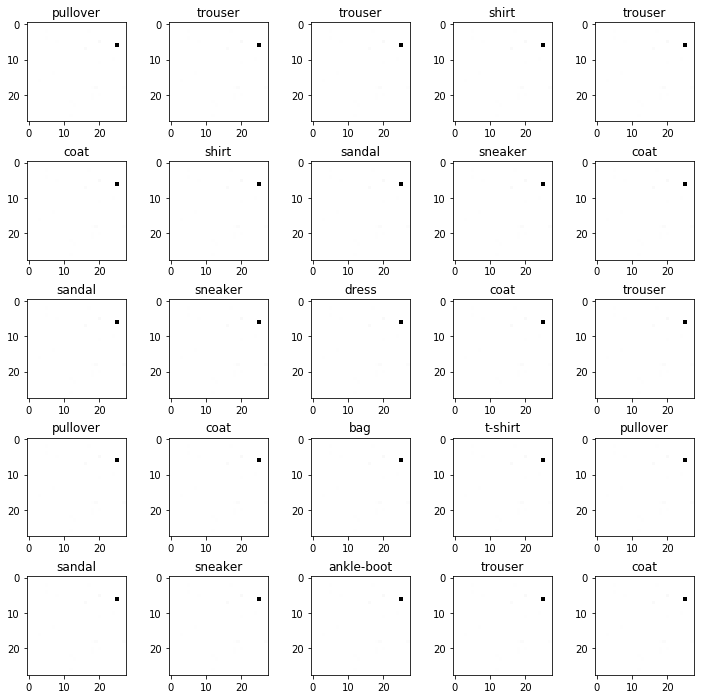

In [0]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 5
rows = 5
pred = autoencoder.predict(x_val_vector)
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i].reshape(28,28),cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

* ¿Qué función de activación debe utilizar para la capa de salida? ¿Le parece sea una buena aproximación comparando con las caracteristicas de la red anterior?

Una lineal o ReLU que tenga en su dominio de salida los valores 0-255, el problema que no hay una forma de acotarlo y se puede ver como no es una buena aproximación, otro problema peude ser el cambio de funciones en las capas ocultas de la red.

### 2.e Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

In [0]:
h_neuron = [2,32,64,128,246,x_train[1].size/2,500,600]
hists = list()

for n in h_neuron:
  autoencoder = Sequential()
  autoencoder.add(Dense(n,activation='relu')) # encoder
  autoencoder.add(Dense(28*28,activation='sigmoid')) #decoder
  autoencoder.compile(loss='binary_crossentropy', optimizer='sgd')
  history = autoencoder.fit(x_train_vector_scal,x_train_vector_scal,epochs=50,validation_data=(x_val_vector_scal,x_val_vector_scal))
  hists.append(history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.6915 - val_loss: 0.6892
Epoch 2/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.6819 - val_loss: 0.6681
Epoch 3/50
60000/60000 [==============================] - 5s 92us/step - loss: 0.6303 - val_loss: 0.5837
Epoch 4/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5504 - val_loss: 0.5304
Epoch 5/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5236 - val_loss: 0.5200
Epoch 6/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.5176 - val_loss: 0.5163
Epoch 7/50
60000/60000 [==============================] - 6s 92us/step - loss: 0.5148 - val_loss: 0.5142
Epoch 8/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.5129 - val_loss: 0.5125
Epoch 9/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5114 - val_loss: 0.5112
Epoch

TypeError: ignored

In [0]:
h_neuron = [int(x_train[1].size/2),500,600]

for n in h_neuron:
  autoencoder = Sequential()
  autoencoder.add(Dense(n,activation='relu')) # encoder
  autoencoder.add(Dense(28*28,activation='sigmoid')) #decoder
  autoencoder.compile(loss='binary_crossentropy', optimizer='sgd')
  history = autoencoder.fit(x_train_vector_scal,x_train_vector_scal,epochs=50,validation_data=(x_val_vector_scal,x_val_vector_scal))
  hists.append(history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.6500 - val_loss: 0.5909
Epoch 2/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5479 - val_loss: 0.5224
Epoch 3/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.5124 - val_loss: 0.5053
Epoch 4/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.4988 - val_loss: 0.4933
Epoch 5/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.4868 - val_loss: 0.4813
Epoch 6/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.4748 - val_loss: 0.4693
Epoch 7/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.4630 - val_loss: 0.4580
Epoch 8/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.4523 - val_loss: 0.4480
Epoch 9/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.4428 - val_loss: 0.4391
Epoc

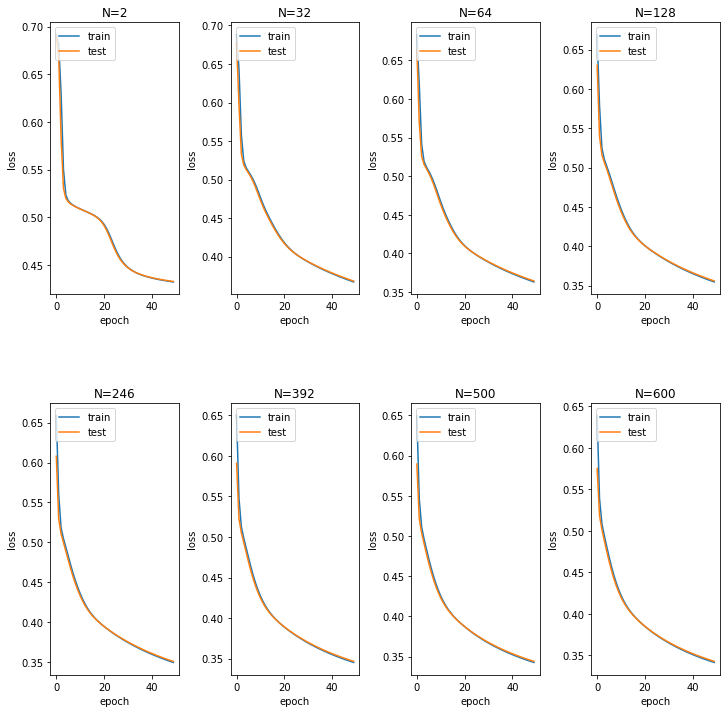

In [0]:
h_neuron = [2,32,64,128,246,int(x_train[1].size/2),500,600]
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 4
rows = 2
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    # summarize history for loss
    history = hists[i-1]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('N='+str(h_neuron[i-1]))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Análisis

Por un lado se puede observar que entre mayor era la dimensionalidad a la cual se comprimia, el avance de la red es más suavizado. Además se puede ver que entre aumenta la dimensionalidad, mejoran las métricas.

### 2.f Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. 

¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 


In [0]:
h_neuron = [2,32,64,128,246,int(x_train[1].size/2),500,600]
hists = list()

for n in h_neuron:
  autoencoder = Sequential()
  autoencoder.add(Dense(500,activation='relu')) # encoder
  autoencoder.add(Dense(400,activation='relu')) # encoder
  autoencoder.add(Dense(n,activation='relu')) # encoder
  autoencoder.add(Dense(400,activation='relu')) #decoder
  autoencoder.add(Dense(28*28,activation='sigmoid')) #decoder
  autoencoder.compile(loss='binary_crossentropy', optimizer='sgd')
  history = autoencoder.fit(x_train_vector_scal,x_train_vector_scal,epochs=50,validation_data=(x_val_vector_scal,x_val_vector_scal))
  hists.append(history)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 16s 262us/step - loss: 0.6916 - val_loss: 0.6898
Epoch 2/50
60000/60000 [==============================] - 6s 108us/step - loss: 0.6840 - val_loss: 0.6696
Epoch 3/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.5954 - val_loss: 0.5250
Epoch 4/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.5136 - val_loss: 0.5085
Epoch 5/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.5045 - val_loss: 0.5015
Epoch 6/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.4973 - val_loss: 0.4943
Epoch 7/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.4903 - val_loss: 0.4882
Epoch 8/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.4852 - val_loss: 0

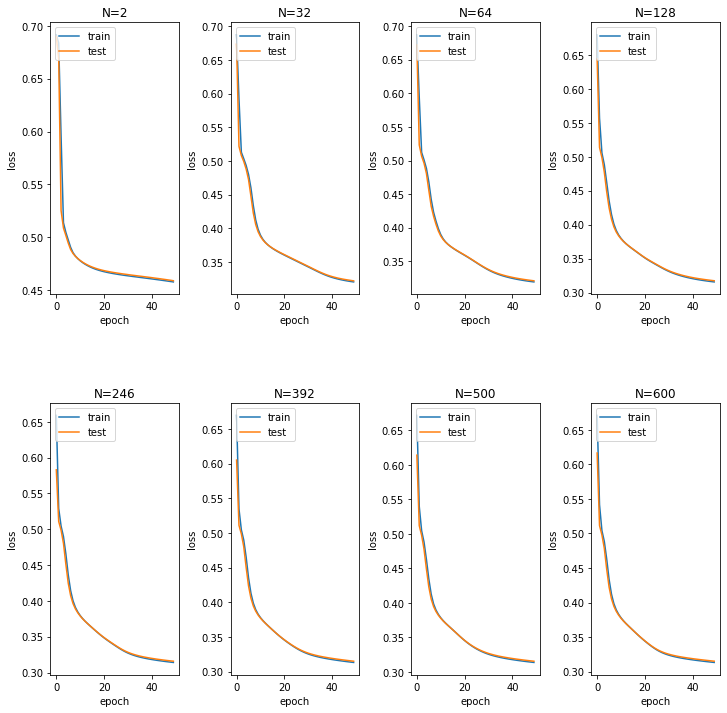

In [0]:
h_neuron = [2,32,64,128,246,int(x_train[1].size/2),500,600]
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 4
rows = 2
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    # summarize history for loss
    history = hists[i-1]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('N='+str(h_neuron[i-1]))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

* ¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

  Aumenta en gran cantidad, sobretodo porque por lo general al agregar una capa en encoder igual uno agrega o modifica el decoder, para que pueda descifrar la complejidad. La representación sigue siendo la misma que uno deje "en medio" del AE. El comportamiento según dimensión, se ve que mejora al incrementar dimensión. 

* ¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

  Para las de mayor dimensión no hay gran diferencia, y es peor para muy ocas pero para un punto medio como 128, muetra un mejor desempeño que en comparación al AE shallow.

### 2.g Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/

In [0]:
autoencoder_conv = Sequential()

# Encoder Layers
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder_conv.add(Flatten())
autoencoder_conv.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))


autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

#autoencoder_conv.add(Deconvolution2D(64, 2, strides=2,activation='relu', padding='same'))
# autoencoder_conv.add(Deconvolution2D(1, 2, strides=2,activation='sigmoid', padding='same'))

autoencoder_conv.summary()

autoencoder_conv.compile(loss='binary_crossentropy', optimizer='sgd')    
x_tr = x_train_scal.reshape(len(x_train_scal),28,28,1)
x_val = x_val_scal.reshape(len(x_val_scal),28,28,1)
history = autoencoder_conv.fit(x_tr, x_tr, epochs=50,validation_data=(x_val,x_val))


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 4, 8)         

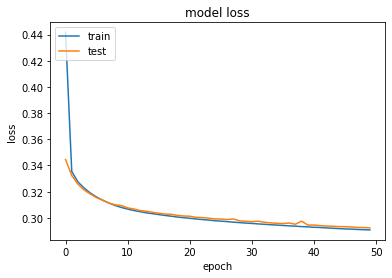

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

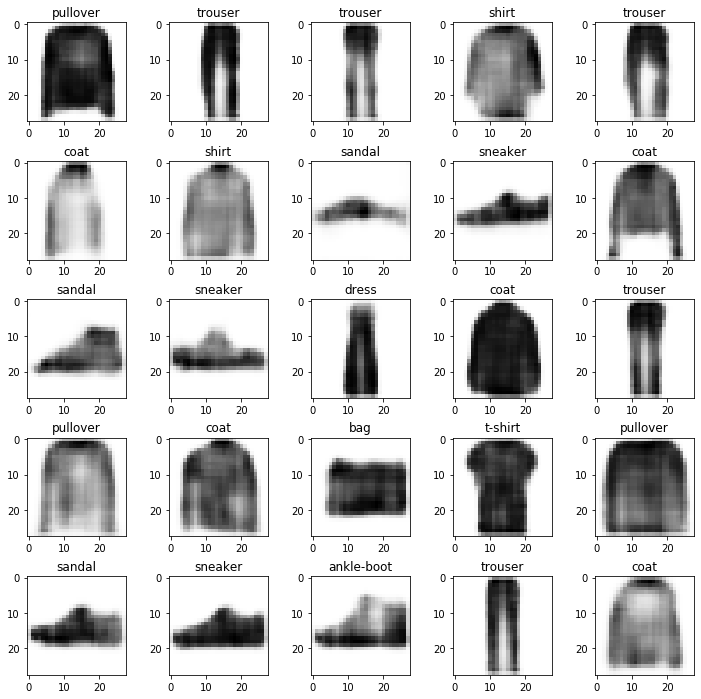

In [0]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 5
rows = 5
pred = autoencoder_conv.predict(x_val)
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

#### Análisis
Se ve una imagen más definida que en la red FF, demostrando que una convolucional al tener la cualidad de captar cualidades espaciales (los pixeles y sus vecindades), capta mejor las variables latentes de manera de reconstruirla.

### 2.h Transfer Learning y reducción de dimensionalidad

Como mencionamos inicialmente, una de las utilidades de los autoencoders corresponde a la no necesidad de tener etiquetas. En ese caso, podemos utilizar los autoencoders para extraer representaciones significativas de los ejemplos no etiquetados, y luego utilizar ese conocimiento para mejorar el desempeño de nuestros algoritmos. 

Para simular esta tarea supongamos que tenemos la misma base de datos original, sin embargo solo poseemos un pequeño porcentaje de las etiquetas del conjunto de entrenamiento, menos del $5\%$ (considere que si tuviera que etiquetar manualmente incluso solo un $5\%$ correspondería a 3000 imagenes por etiquetar!).

Seleccione un subconjunto de datos correspondiente a menos del $5\%$ de los datos y entrene un modelo predictivo para el problema de clasificación. Si bien la aproximación convolucional suele ser la mejor para este tipo de bases de datos, utilice arquitectura densa. 

Luego, utilizando el mejor autoencoder entrenado hasta ahora (o entrene uno nuevo si prefiere), utilize lo aprendido por la red sobre el conjunto de datos sin etiquetas para intentar aprender la relación suyaciente. Para esto, lo más fácil es primero preprocesar el conjunto `x` de entrenamiento, utilizando la sección de encoding de su autoencoder. Puede crear un nuevo modelo secuencial solo con las capas de encoding como se muestra en el código y luego usar el método `.predict` del modelo. Luego sobre estos datos preprocesados entrene un nuevo modelo predictivo fully connected. 

La otra opción sería crear un modelo cuya primeras capas correspondan a la sección de encoding del autoencoder y las últimas capas a su modelo denso, pero fijando el atributo `trainable` de las primeras capas como `False`, sin embargo esto resulta poco eficiente. 


Comente sus resultados basándose en métricas adecuadas. Comente igualmente sobre la dimensionalidad de las representaciones utilizadas por cada uno de los dos modelos entrenados en esta sección y el número de parametros _entrenables_ y totales del modelo (considerando el encoding). 

Considerando la dimensionalidad obtenida por el encoder, compare la calidad de la representación obtenida por el autoencoder frente a otras aproximaciones de reducción de dimensionalidad, como por ejemplo Principal Component Analysis (PCA). Para esto, transforme los datos de entrenamiento utilizando PCA con un número de componentes principales igual a la dimensión de la representación engendrada por su encoder. Compare el desempeño de un modelo determinado utilizando ambas representaciones. 

Comente sus resultados.

In [0]:
from sklearn.model_selection import train_test_split

x_tr, x_lab, y_tr, y_lab = train_test_split(x_train, y_train, test_size=0.04, random_state=42)
x_tr = x_tr/255
x_lab = x_lab/255

In [0]:
x_lab.shape

(2400, 28, 28)

In [0]:
encoder = Sequential()
d = 128
best_autoencoder = autoencoder_conv
encoder.add(best_autoencoder.get_layer(index=0))
encoder.add(best_autoencoder.get_layer(index=1))
encoder.add(best_autoencoder.get_layer(index=2))
encoder.add(best_autoencoder.get_layer(index=3))
encoder.add(best_autoencoder.get_layer(index=4))
encoder.add(best_autoencoder.get_layer(index=5))
encoder.summary()
    
from sklearn.decomposition import PCA

pca = PCA(n_components=d)
x_pca = pca.fit_transform(x_lab.reshape(-1,28*28))
print(x_pca.shape)

x_lab = x_lab.reshape(len(x_lab),28,28,1)
x_emb = encoder.predict(x_lab)    
print(x_emb.shape)

hists = list()
  

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
___________________________________________________

#### PCA

Train on 1608 samples, validate on 792 samples
Epoch 1/30
1608/1608 [==============================] - 1s 780us/step - loss: 2.1347 - acc: 0.2537 - val_loss: 1.4286 - val_acc: 0.6199
Epoch 2/30
1608/1608 [==============================] - 0s 25us/step - loss: 1.5235 - acc: 0.4596 - val_loss: 1.0481 - val_acc: 0.6806
Epoch 3/30
1608/1608 [==============================] - 0s 22us/step - loss: 1.2656 - acc: 0.5479 - val_loss: 0.8786 - val_acc: 0.7121
Epoch 4/30
1608/1608 [==============================] - 0s 22us/step - loss: 1.1294 - acc: 0.5951 - val_loss: 0.7485 - val_acc: 0.7449
Epoch 5/30
1608/1608 [==============================] - 0s 24us/step - loss: 0.9903 - acc: 0.6561 - val_loss: 0.7144 - val_acc: 0.7563
Epoch 6/30
1608/1608 [==============================] - 0s 22us/step - loss: 0.9439 - acc: 0.6561 - val_loss: 0.6548 - val_acc: 0.7664
Epoch 7/30
1608/1608 [==============================] - 0s 22us/step - loss: 0.8487 - acc: 0.6978 - val_loss: 0.6205 - val_acc: 0.7677
Epoch 8

Text(0.5, 1.0, 'Accuracy Curves')

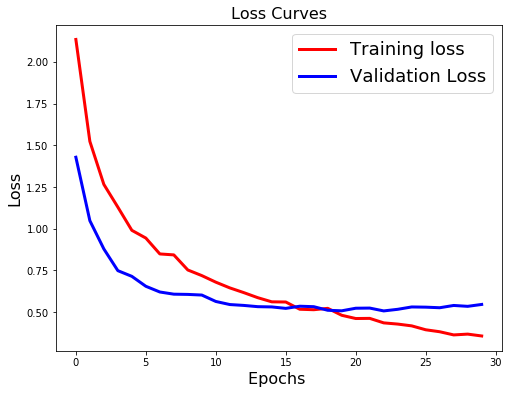

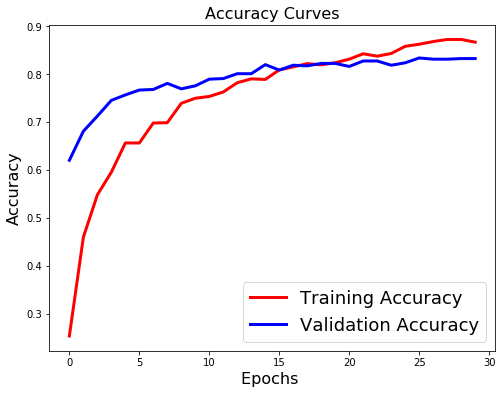

In [0]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(x_pca, y_lab, test_size=0.33, random_state=42)

classes = np.unique(y_lab) #CHecks for unique labels in the traning labels 
nClasses = len(classes) #length of the output

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(128,))) # 1st hidden layer
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) # 2nd hidden layer
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) # 2nd hidden layer
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax')) #softmax for multi class classification
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, train_labels_one_hot, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, test_labels_one_hot))

[test_loss, test_acc] = model.evaluate(X_test, test_labels_one_hot)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Emb

Train on 1608 samples, validate on 792 samples
Epoch 1/50
1608/1608 [==============================] - 1s 908us/step - loss: 2.4189 - acc: 0.1604 - val_loss: 1.7760 - val_acc: 0.3598
Epoch 2/50
1608/1608 [==============================] - 0s 30us/step - loss: 1.8320 - acc: 0.3116 - val_loss: 1.3847 - val_acc: 0.5467
Epoch 3/50
1608/1608 [==============================] - 0s 24us/step - loss: 1.5616 - acc: 0.3993 - val_loss: 1.2066 - val_acc: 0.5833
Epoch 4/50
1608/1608 [==============================] - 0s 26us/step - loss: 1.4196 - acc: 0.4422 - val_loss: 1.0840 - val_acc: 0.5657
Epoch 5/50
1608/1608 [==============================] - 0s 33us/step - loss: 1.3408 - acc: 0.4801 - val_loss: 1.0410 - val_acc: 0.5871
Epoch 6/50
1608/1608 [==============================] - 0s 31us/step - loss: 1.2431 - acc: 0.4932 - val_loss: 0.9457 - val_acc: 0.6149
Epoch 7/50
1608/1608 [==============================] - 0s 24us/step - loss: 1.1922 - acc: 0.5404 - val_loss: 0.9094 - val_acc: 0.6035
Epoch 8

Text(0.5, 1.0, 'Accuracy Curves')

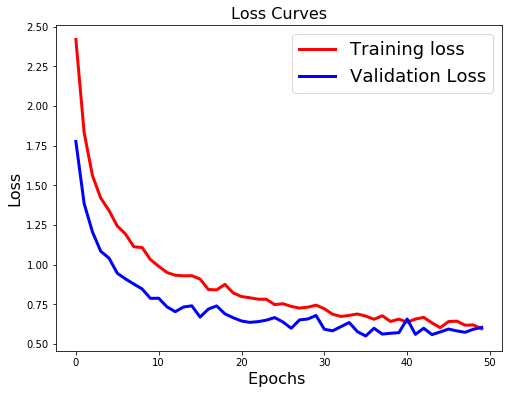

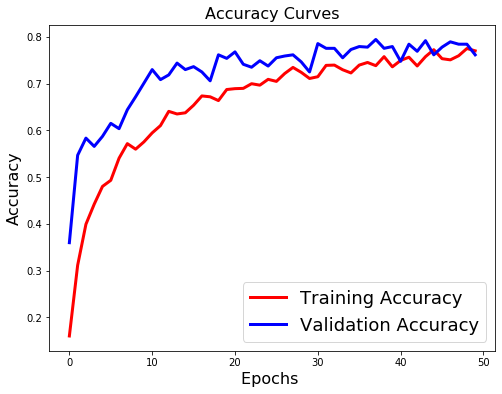

In [0]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(x_emb, y_lab, test_size=0.33, random_state=42)

classes = np.unique(y_lab) #CHecks for unique labels in the traning labels 
nClasses = len(classes) #length of the output

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(128,))) # 1st hidden layer
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) # 2nd hidden layer
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) # 2nd hidden layer
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax')) #softmax for multi class classification
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, train_labels_one_hot, batch_size=256, epochs=50, verbose=1, validation_data=(X_test, test_labels_one_hot))

[test_loss, test_acc] = model.evaluate(X_test, test_labels_one_hot)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Comentarios
Para PCA muestra mejroes desempeños pero a la vez se sobreajusta en mayor medida, igual se probaron con otros optimizadores y ocurría de manera más rápida aún el sobreajuste, pero con una precisión parecida. Para el embedding muestra que no llega al sobreajuste pero es un entrenamiento mucho mas "suavizado" el que lleva en el tiempo. Esto puede ocurrir debido a que PCA al ser lineal, la red se memoriza mucho más fácil en comparación a algo no lineal como es el embedding. 

### 2.i Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy` o utilizar por ejemplo el `ImageDataGenerator` que utilizamos en la tarea anterior para generar imágenes similares con las cuales "sumar" ruido. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patron de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imagen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida. Pruebe igualmente entregarle a la red nuevas.

In [0]:
# Save augmented images to file
from keras.preprocessing.image import ImageDataGenerator
import os

# load data
(x_train,y_train),(x_val,y_val) = fashion_mnist.load_data()

x_train_scal = x_train/255
x_val_scal = x_val/255
x_val_vector = x_val.reshape(-1,28*28)
x_val_vector_scal = x_val_scal.reshape(-1,28*28)
x_train_vector = x_train.reshape(-1,28*28)
x_train_vector_scal = x_train_scal.reshape(-1,28*28)

x_tr = x_train_scal.reshape(len(x_train_scal),28,28,1)
x_val = x_val_scal.reshape(len(x_val_scal),28,28,1)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_tr)

autoencoder_conv = Sequential()

# Encoder Layers
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder_conv.add(Flatten())
autoencoder_conv.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))


autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder_conv.summary()

autoencoder_conv.compile(loss='binary_crossentropy', optimizer='rmsprop')    
#history = autoencoder_conv.fit(x_tr, x_tr, epochs=50,validation_data=(x_val,x_val))

# fits the model on batches with real-time data augmentation:
history = autoencoder_conv.fit_generator(datagen.flow(x_tr, x_tr, batch_size=32), steps_per_epoch=len(x_train) / 32, epochs=20,validation_data=(x_val,x_val))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 8)          

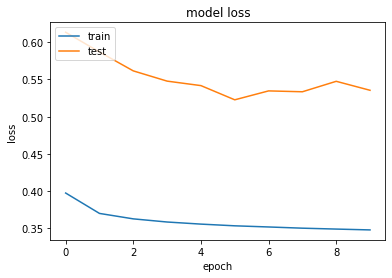

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

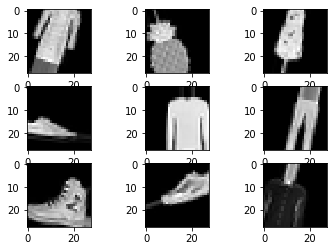

In [0]:
# Datagen
for X_batch, y_batch in datagen.flow(x_tr, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

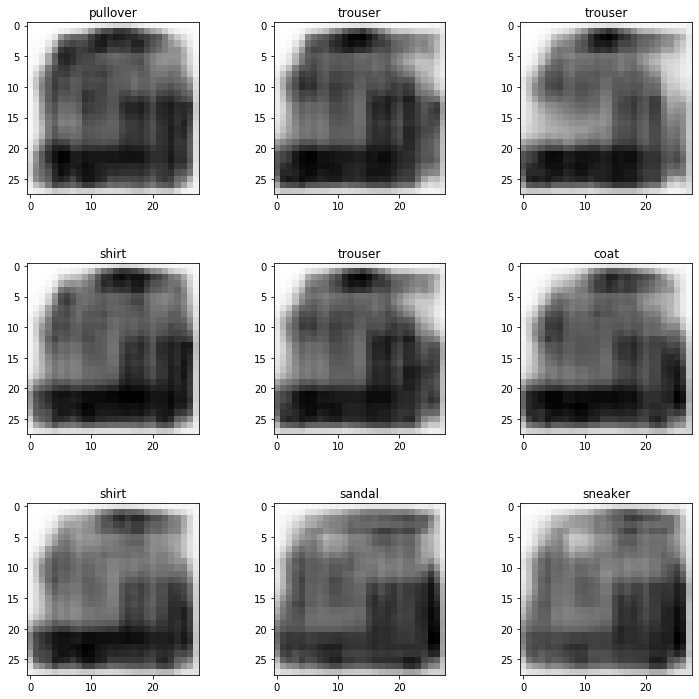

****************************************************


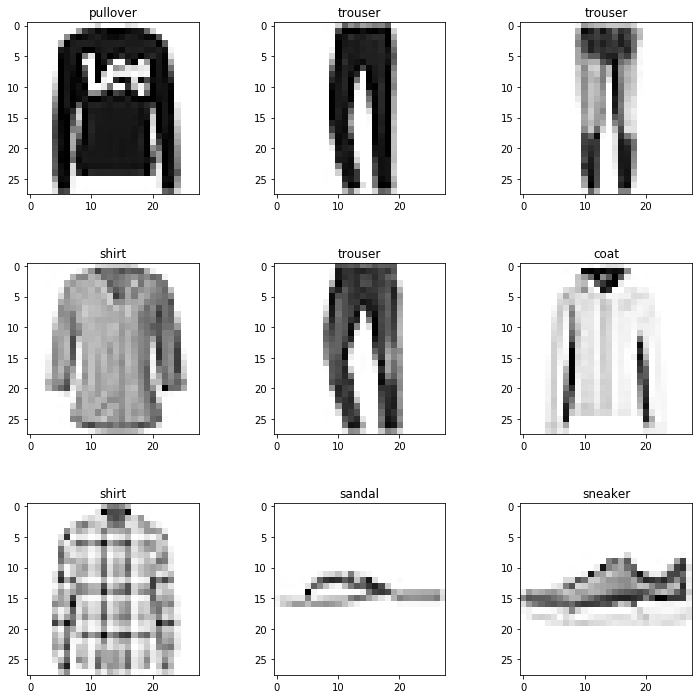

In [0]:
# predict
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 3
rows = 3
pred = autoencoder_conv.predict(x_val)
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

print('****************************************************')

# original
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 3
rows = 3
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_val[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

#### Comentario
En este punto en vez del ruido, que encuentramos no sería muy realista. Ocupamos diferentes modificaciones en la imagen, de tal manera de ver como se comportaba y el desempeño fue directamente muy malo. El resultado igual era esperado, debido a que al ver los resultados que generaban las redes por lo general se enfocaban en la silueta y al tener rotaciones y demás, distorsionaba estas. Generando imágenes irreconocibles.

### 2.j Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imagenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imagen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imagenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imagen resultante utilizando el decoder. ¿Qué observa? Muestre las imagenes obtenidas junto con otras imagenes de la misma categoría que la imagen que utilizó originalmente. Preube con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imagen obtenida al promediar las representaciones comprimidas de varias (o todas) las imagenes de una clase. Utilice el encoder para generar imagenes a partir de otros valores que se les ocurran y especule sobre el por qué la imagen obtenida se asimila o no a las imagenes del dataset. 

In [0]:
autoencoder_conv = Sequential()

# Encoder Layers
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_conv.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder_conv.add(Flatten())
autoencoder_conv.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))


autoencoder_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

#autoencoder_conv.add(Deconvolution2D(64, 2, strides=2,activation='relu', padding='same'))
# autoencoder_conv.add(Deconvolution2D(1, 2, strides=2,activation='sigmoid', padding='same'))

autoencoder_conv.summary()

autoencoder_conv.compile(loss='binary_crossentropy', optimizer='sgd')    
x_tr = x_train_scal.reshape(len(x_train_scal),28,28,1)
x_val = x_val_scal.reshape(len(x_val_scal),28,28,1)
history = autoencoder_conv.fit(x_tr, x_tr, epochs=50,validation_data=(x_val,x_val))

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_10 (Flatten)         (None, 128)               0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 4, 8)         

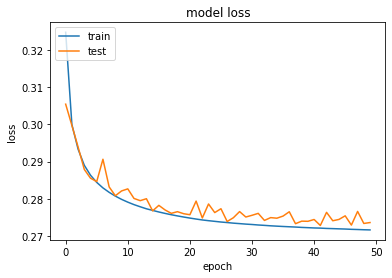

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

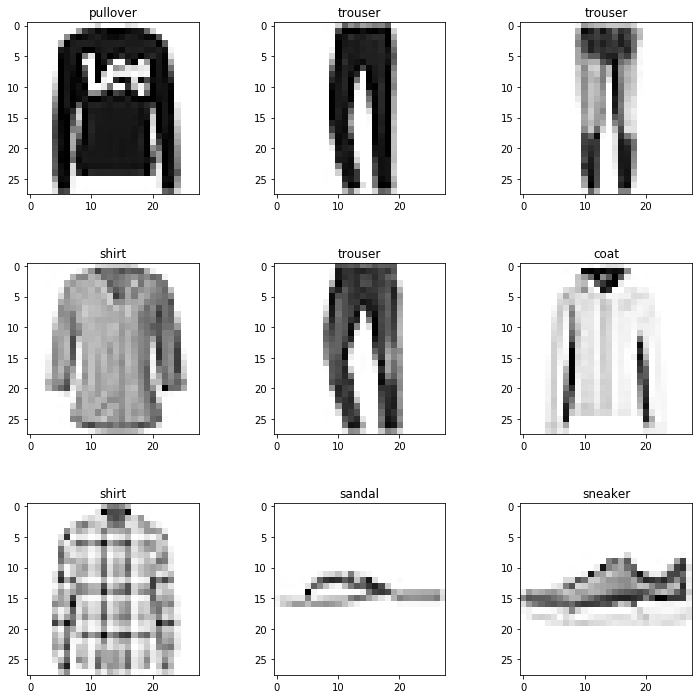

 DATA GEN 


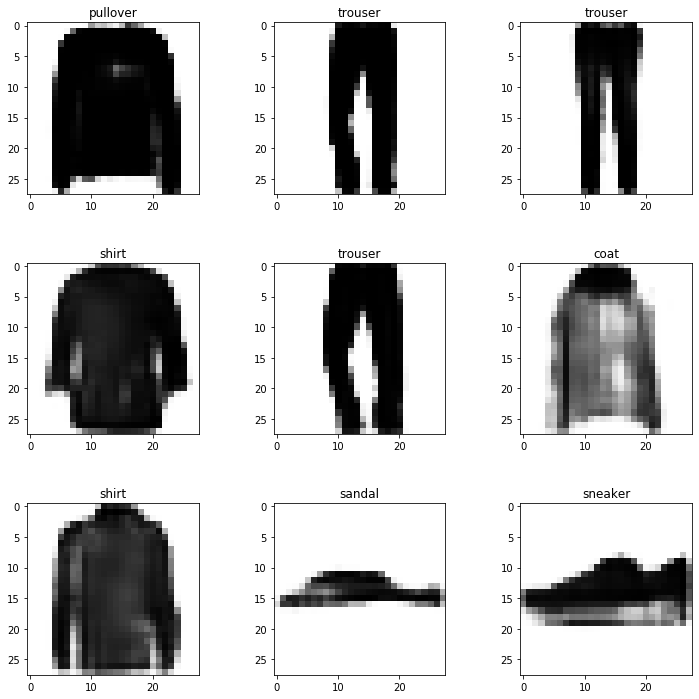

In [0]:
# do it yourself
encoder = Sequential()
best_autoencoder = autoencoder_conv
encoder.add(best_autoencoder.get_layer(index=0))
encoder.add(best_autoencoder.get_layer(index=1))
encoder.add(best_autoencoder.get_layer(index=2))
encoder.add(best_autoencoder.get_layer(index=3))
encoder.add(best_autoencoder.get_layer(index=4))
encoder.add(best_autoencoder.get_layer(index=5))

x_val = x_val_scal.reshape(len(x_val_scal),28,28,1)
pred = encoder.predict(x_val)

# noise apply to data
noise = np.random.normal(0,0.1,pred.shape)
noise_data = pred*2

decoder = Sequential()
decoder.add(best_autoencoder.get_layer(index=6))
decoder.add(best_autoencoder.get_layer(index=7))
decoder.add(best_autoencoder.get_layer(index=8))
decoder.add(best_autoencoder.get_layer(index=9))
decoder.add(best_autoencoder.get_layer(index=10))
decoder.add(best_autoencoder.get_layer(index=11))
decoder.add(best_autoencoder.get_layer(index=12))
decoder.add(best_autoencoder.get_layer(index=13))

gen = decoder.predict(noise_data)

# original
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 3
rows = 3
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_val[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

print(' DATA GEN ')

# original
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace = 0.4,hspace=0.4)
columns = 3
rows = 3
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen[i].reshape(28,28)*255,cmap='Greys')
    plt.title(labels[y_val[i]])
plt.show()

#### Comentario
Se visualiza la data real y la generada, el ruido no fue graficado por un error. Se ocupo un ruido normal, el cual para valores bajos (como 0.1 mostrado) generaba imágenes aceptables, pero al ir subiendo la varianza del ruido iba distorsionando en peor medida. En situaciones reales no sería muy aceptable, debido a que genera una imagen negra de la silueta de la ropa.